In [6]:
!nvidia-smi

Thu Mar 14 14:23:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 27%   28C    P8    24W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 29%   

In [7]:
!pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
file_path = 'counterspeech_classification_data.csv'
df = pd.read_csv(file_path)

In [10]:
df.shape

(4082, 2)

In [11]:
df['label'].unique()

array(['warning', 'hypocrisy', 'humor', 'support', 'question',
       'denouncing', 'facts', 'positive tone', 'affiliation'],
      dtype=object)

In [12]:
df['label'].value_counts()

facts            1094
denouncing        738
humor             607
hypocrisy         579
positive tone     315
question          227
warning           184
support           175
affiliation       163
Name: label, dtype: int64

In [13]:
labels = {'hypocrisy':0,
          'contradiction':0,
          'denouncing':1,
          'humor':2,
          'humour':2,
          'facts':3,
          'affiliation':4,
          'question':5,
          }
valid_labels = ['hypocrisy', 'contradiction', 'denouncing', 'humor', 'humour','facts', 'affiliation', 'question']

df_filtered = df[df['label'].isin(valid_labels)]

In [14]:
df_filtered

,label,processed_counterspeech
1,hypocrisy,that woman is ruff as bags ewh nasty 🤮 and wha...
2,humor,gif of someone laughing if islamophobia is get...
3,humor,had lunch with some muslim friends recently so...
4,humor,this happened in new york ? damn the south got...
5,hypocrisy,god does not like people who try to replace or...
...,...,...
4076,hypocrisy,just because hes black the police arrested him...
4077,humor,go on talking to yourself no one will listen
4078,facts,people invited to work in our mills and factor...
4079,facts,it is quite literally not


In [15]:
column_name = 'processed_counterspeech'
nan_count = df_filtered[column_name].isna().sum()
print(f"Number of NaN values in '{column_name}': {nan_count}")

Number of NaN values in 'processed_counterspeech': 0


In [16]:
df_filtered = df_filtered.copy()
df_filtered[column_name] = df_filtered[column_name].astype(str).apply(lambda x: str(x))

In [17]:
df_filtered[column_name].dtype

dtype('O')

In [18]:
all_types = df_filtered[column_name].apply(lambda x: type(x))

unique_types = all_types.unique()
print("Unique Python types in the column:")
for t in unique_types:
    print(t)

Unique Python types in the column:
<class 'str'>


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['processed_counterspeech']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [20]:
df_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=1, stratify=df_filtered['label'])

<AxesSubplot:xlabel='label'>

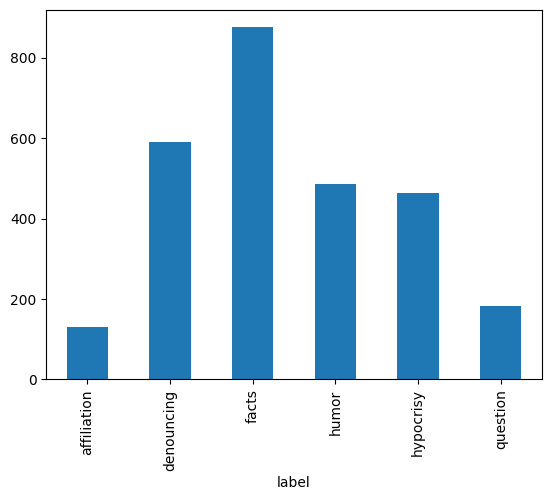

In [21]:
df_train.groupby(['label']).size().plot.bar()

In [20]:
# df_use_for_prompts.to_csv("./prompts_generation_data.csv",index=False)

In [21]:
# df_use_for_classification.to_csv("./counterspeech_classification_data.csv",index=False)

In [22]:
df_test,df_val = train_test_split(df_test, test_size=0.5, random_state=1, stratify=df_test['label'])

In [23]:
df_train

,label,processed_counterspeech
3225,humor,i herd them say amen after he said crack that ...
3435,hypocrisy,muslims really want all jews to unite in one l...
607,affiliation,hey i am a jew this is very offensive to me
3118,denouncing,how will being angry and violent towards membe...
1969,hypocrisy,and then they get away with it because they ha...
...,...,...
3749,hypocrisy,the only cover up i remember was in the cathol...
3993,denouncing,to be fair i would guess its hard to feel a se...
2269,denouncing,this is disgusting
525,affiliation,this really shitty and stupid social expirimen...


In [24]:
df_train['label'].unique()

array(['humor', 'hypocrisy', 'affiliation', 'denouncing', 'question',
       'facts'], dtype=object)

In [25]:
df_val['label'].unique()

array(['facts', 'hypocrisy', 'affiliation', 'humor', 'denouncing',
       'question'], dtype=object)

In [38]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.softmax = nn.Softmax()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)

        return final_layer

In [39]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs, cuda_device=1):

    train, val = Dataset(train_data), Dataset(val_data)
    best_acc = 0
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)
    es = 0
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:{}".format(cuda_device) if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    if use_cuda:
        model = model.to(device)
        criterion = criterion.to(device)

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')

        val_acc = total_acc_val / len(val_data)
        if val_acc > best_acc:
            best_acc = val_acc
            es = 0
            torch.save(model.state_dict(), "checkpoint_6.pt")
        else:
            es += 1
            print("Counter {} of 5".format(es))

            if es > 4:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_acc, "...")
                break

    model.load_state_dict(torch.load('checkpoint_6.pt'))

EPOCHS = 30
model = BertClassifier()
LR = 1e-5

# Change cuda_device to 1 to use CUDA on device 1
train(model, df_train, df_val, LR, EPOCHS, cuda_device=1)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 1 | Train Loss:  0.103             | Train Accuracy:  0.413             | Val Loss:  0.098             | Val Accuracy:  0.537


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 2 | Train Loss:  0.090             | Train Accuracy:  0.632             | Val Loss:  0.090             | Val Accuracy:  0.669


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 3 | Train Loss:  0.082             | Train Accuracy:  0.756             | Val Loss:  0.087             | Val Accuracy:  0.677


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 4 | Train Loss:  0.077             | Train Accuracy:  0.827             | Val Loss:  0.085             | Val Accuracy:  0.730


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 5 | Train Loss:  0.074             | Train Accuracy:  0.869             | Val Loss:  0.085             | Val Accuracy:  0.716
Counter 1 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 6 | Train Loss:  0.072             | Train Accuracy:  0.905             | Val Loss:  0.084             | Val Accuracy:  0.730
Counter 2 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 7 | Train Loss:  0.070             | Train Accuracy:  0.930             | Val Loss:  0.083             | Val Accuracy:  0.751


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 8 | Train Loss:  0.069             | Train Accuracy:  0.944             | Val Loss:  0.084             | Val Accuracy:  0.742
Counter 1 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 9 | Train Loss:  0.069             | Train Accuracy:  0.951             | Val Loss:  0.082             | Val Accuracy:  0.762


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 10 | Train Loss:  0.069             | Train Accuracy:  0.953             | Val Loss:  0.082             | Val Accuracy:  0.768


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 11 | Train Loss:  0.068             | Train Accuracy:  0.959             | Val Loss:  0.082             | Val Accuracy:  0.768
Counter 1 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 12 | Train Loss:  0.068             | Train Accuracy:  0.962             | Val Loss:  0.082             | Val Accuracy:  0.762
Counter 2 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 13 | Train Loss:  0.068             | Train Accuracy:  0.966             | Val Loss:  0.082             | Val Accuracy:  0.760
Counter 3 of 5


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 14 | Train Loss:  0.068             | Train Accuracy:  0.968             | Val Loss:  0.081             | Val Accuracy:  0.780


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 15 | Train Loss:  0.067             | Train Accuracy:  0.969             | Val Loss:  0.081             | Val Accuracy:  0.789


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 16 | Train Loss:  0.068             | Train Accuracy:  0.967             | Val Loss:  0.083             | Val Accuracy:  0.739
Counter 1 of 5


100%|█████████████████████████████████████████| 171/171 [02:21<00:00,  1.21it/s]


Epochs: 17 | Train Loss:  0.067             | Train Accuracy:  0.970             | Val Loss:  0.083             | Val Accuracy:  0.751
Counter 2 of 5


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 18 | Train Loss:  0.067             | Train Accuracy:  0.970             | Val Loss:  0.082             | Val Accuracy:  0.762
Counter 3 of 5


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 19 | Train Loss:  0.067             | Train Accuracy:  0.970             | Val Loss:  0.082             | Val Accuracy:  0.762
Counter 4 of 5


100%|█████████████████████████████████████████| 171/171 [02:20<00:00,  1.21it/s]


Epochs: 20 | Train Loss:  0.067             | Train Accuracy:  0.971             | Val Loss:  0.084             | Val Accuracy:  0.739
Counter 5 of 5
Early stopping with best_acc:  0.7888563049853372 and val_acc for this epoch:  0.7390029325513197 ...


In [48]:
torch.save(model, 'classifier.pt')

In [40]:
pred=[]
true_labels=[]
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              
              acc = (output.argmax(dim=1) == test_label).sum().item()
              true_labels.append(test_label.cpu())
              pred.append(output.argmax(dim=1).cpu())
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

/srv/home/saha/anaconda3/envs/counterspeech/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy:  0.792


In [41]:
true_labels = [label.item() for tensor in true_labels for label in tensor]
pred = [label.item() for tensor in pred for label in tensor]

In [42]:
from sklearn.metrics import confusion_matrix

cf_matrix=confusion_matrix(true_labels,pred)

In [43]:
pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

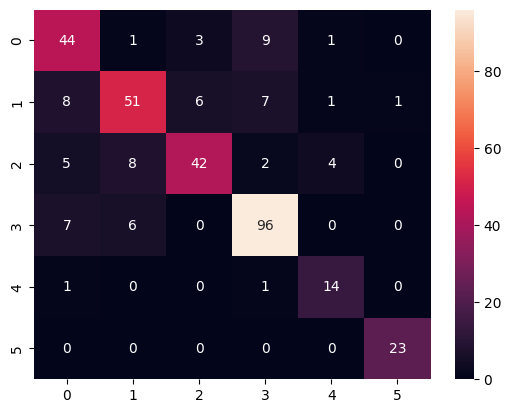

In [44]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [45]:
# labels = {'positive tone':0,
#           'hypocrisy':1,
#           'denouncing':2,
#           'humor':3,
#           'facts':4,
#           'affiliation':5,
#           'warning':6,
#           'support':7,
#           'question':8
#           }
# The order is same
from sklearn.metrics import f1_score
f1_score(true_labels, pred, average=None)

array([0.71544715, 0.72857143, 0.75      , 0.85714286, 0.77777778,
       0.9787234 ])

In [46]:
f1_score(true_labels, pred,average='weighted')

0.790451245878368